<a href="https://colab.research.google.com/github/chiyanglin-AStar/qutip-lectures/blob/master/Lecture-2A-Cavity-Qubit-Gates_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QuTiP lecture: simulation of a two-qubit gate using a resonator as coupler

Author: J.R. Johansson, robert@riken.jp

http://dml.riken.jp/~rob/

Latest version of this ipython notebook lecture are available at: http://github.com/jrjohansson/qutip-lectures

In [20]:
! pip3 install qutip # try to run this notebook in colab

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [22]:
from qutip import *
import math
import qutip as qt

## Parameters

In [23]:
N = 10

wc = 5.0 * 2 * math.pi
w1 = 3.0 * 2 * math.pi
w2 = 2.0 * 2 * math.pi

g1 = 0.01 * 2 * math.pi
g2 = 0.0125 * 2 * math.pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*math.pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*math.pi)/(4 * g2)

### Operators, Hamiltonian and initial state

In [24]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1
sm1 = tensor(qeye(N), destroy(2), qeye(2))
sz1 = tensor(qeye(N), sigmaz(), qeye(2))
n1 = sm1.dag() * sm1

# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
sz2 = tensor(qeye(N), qeye(2), sigmaz())
n2 = sm2.dag() * sm2

In [25]:
# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2

In [26]:
H

Quantum object: dims=[[10, 2, 2], [10, 2, 2]], shape=(40, 40), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-15.70796327   0.           0.         ...   0.           0.
    0.        ]
 [  0.          -3.14159265   0.         ...   0.           0.
    0.        ]
 [  0.           0.           3.14159265 ...   0.           0.
    0.        ]
 ...
 [  0.           0.           0.         ... 279.60174617   0.
    0.        ]
 [  0.           0.           0.         ...   0.         285.88493148
    0.        ]
 [  0.           0.           0.         ...   0.           0.
  298.45130209]]

In [27]:
# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0))

# Ideal two-qubit iSWAP gate

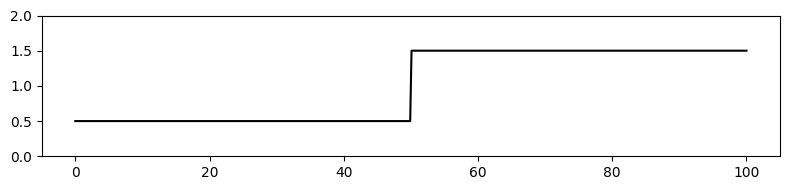

In [28]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t.
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

In [29]:
def wc_t(t, args=None):
    return wc

def w1_t(t, args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t, args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

### Evolve the system

In [30]:
res = mesolve(H_t, psi0, tlist, [], [])

### Plot the results

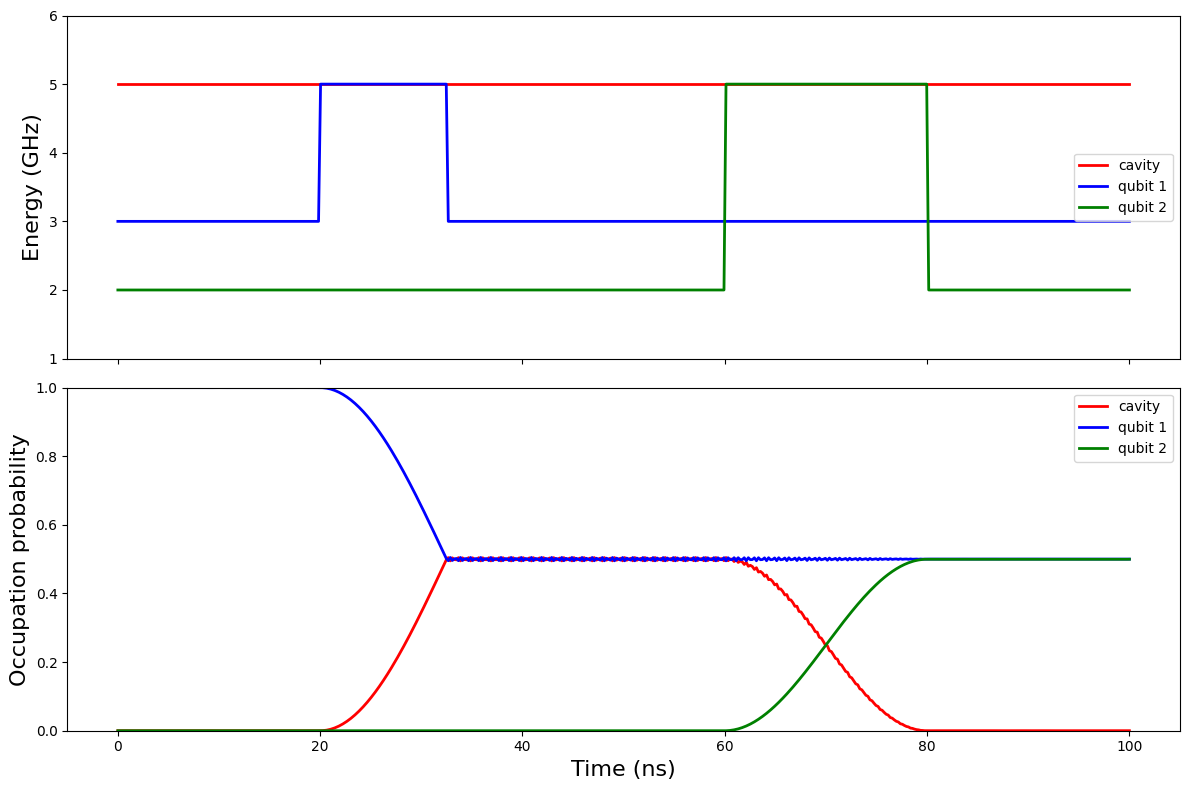

In [31]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Inspect the final state

In [32]:
# extract the final state from the result of the simulation
rho_final = res.states[-1]

In [33]:
# trace out the resonator mode and print the two-qubit density matrix
rho_qubits = ptrace(rho_final, [1,2])
rho_qubits

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 6.16909624e-05+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          4.99792755e-01+0.j
  -4.99575083e-01+0.01984594j  0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j         -4.99575083e-01-0.01984594j
   5.00145554e-01+0.j          0.00000000e+00+0.j        ]
 [ 0.00000000e+00+0.j          0.00000000e+00+0.j
   0.00000000e+00+0.j          0.00000000e+00+0.j        ]]

In [35]:
# compare to the ideal result of the sqrtiswap gate (plus phase correction) for the current initial state
rho_qubits_ideal = ket2dm(tensor(qt.core.gates.phasegate(0), qt.core.gates.phasegate(-math.pi/2)) * qt.core.gates.sqrtiswap() * tensor(basis(2,1), basis(2,0)))
rho_qubits_ideal

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.  0.  0.  0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.5 0.5 0. ]
 [0.  0.  0.  0. ]]

### Fidelity and concurrence

In [36]:
fidelity(rho_qubits, rho_qubits_ideal)

0.019851247466086273

In [37]:
concurrence(rho_qubits)

0.9999382347290824

# Dissipative two-qubit iSWAP gate

### Define collapse operators that describe dissipation



In [40]:
kappa = 0.0001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [math.sqrt(kappa) * a, math.sqrt(gamma1) * sm1, math.sqrt(gamma2) * sm2]

### Evolve the system

In [41]:
res = mesolve(H_t, psi0, tlist, c_ops, [])

### Plot the results

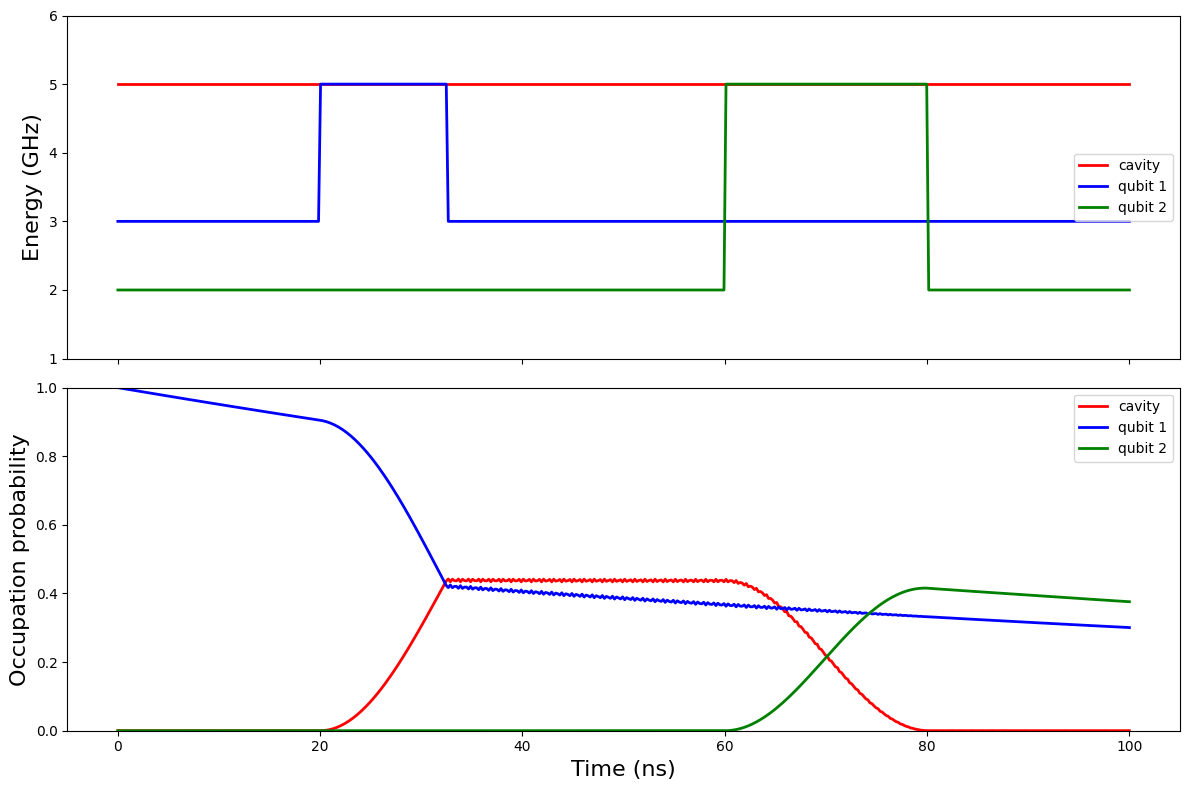

In [44]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [45]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [46]:
fidelity(rho_qubits, rho_qubits_ideal)

1.0746038206307505e-09

In [47]:
concurrence(rho_qubits)

0.6723786036093659

# Two-qubit iSWAP gate: Finite pulse rise time

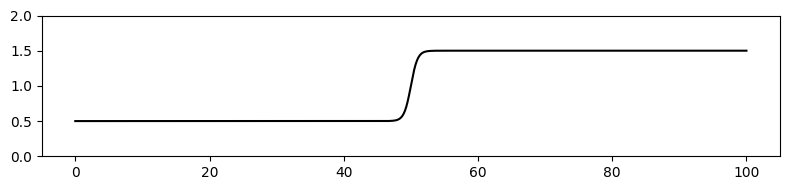

In [49]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time defined
    by the parameter width.
    """
    return w1 + (w2 - w1) / (1 + math.exp(-(t-t0)/width))


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [50]:
res = mesolve(H_t, psi0, tlist, [], [])

### Plot the results

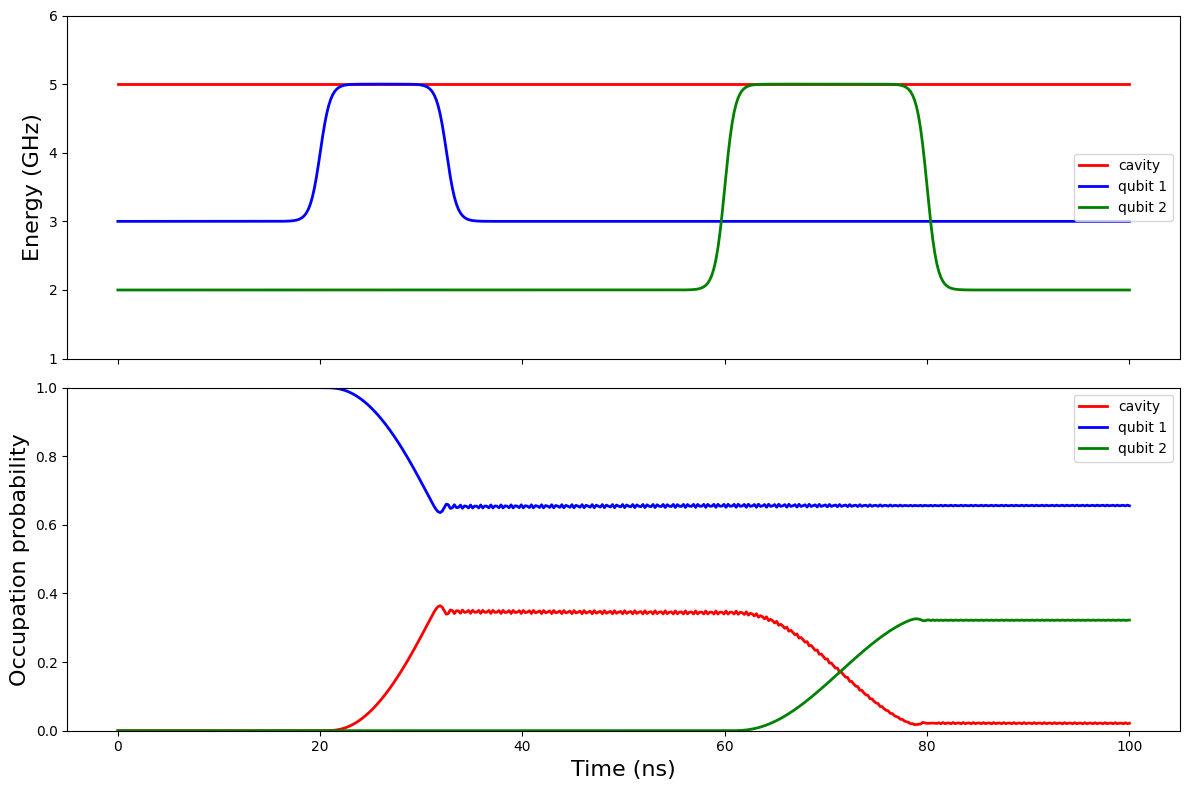

In [52]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [53]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [54]:
fidelity(rho_qubits, rho_qubits_ideal)

0.17834178021546826

In [55]:
concurrence(rho_qubits)

0.9195849018245543

# Two-qubit iSWAP gate: Finite rise time with overshoot

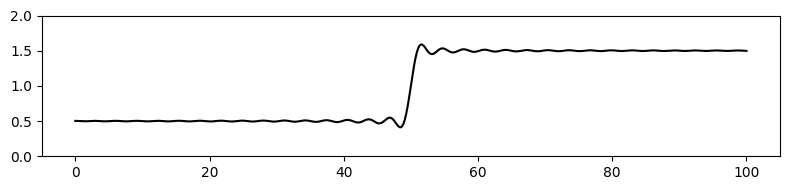

In [57]:
from scipy.special import sici

def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t, with finite rise time and
    and overshoot defined by the parameter width.
    """

    return w1 + (w2-w1) * (0.5 + sici((t-t0)/width)[0]/(math.pi))


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, width, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

### Evolve the system

In [58]:
res = mesolve(H_t, psi0, tlist, [], [])

### Plot the results

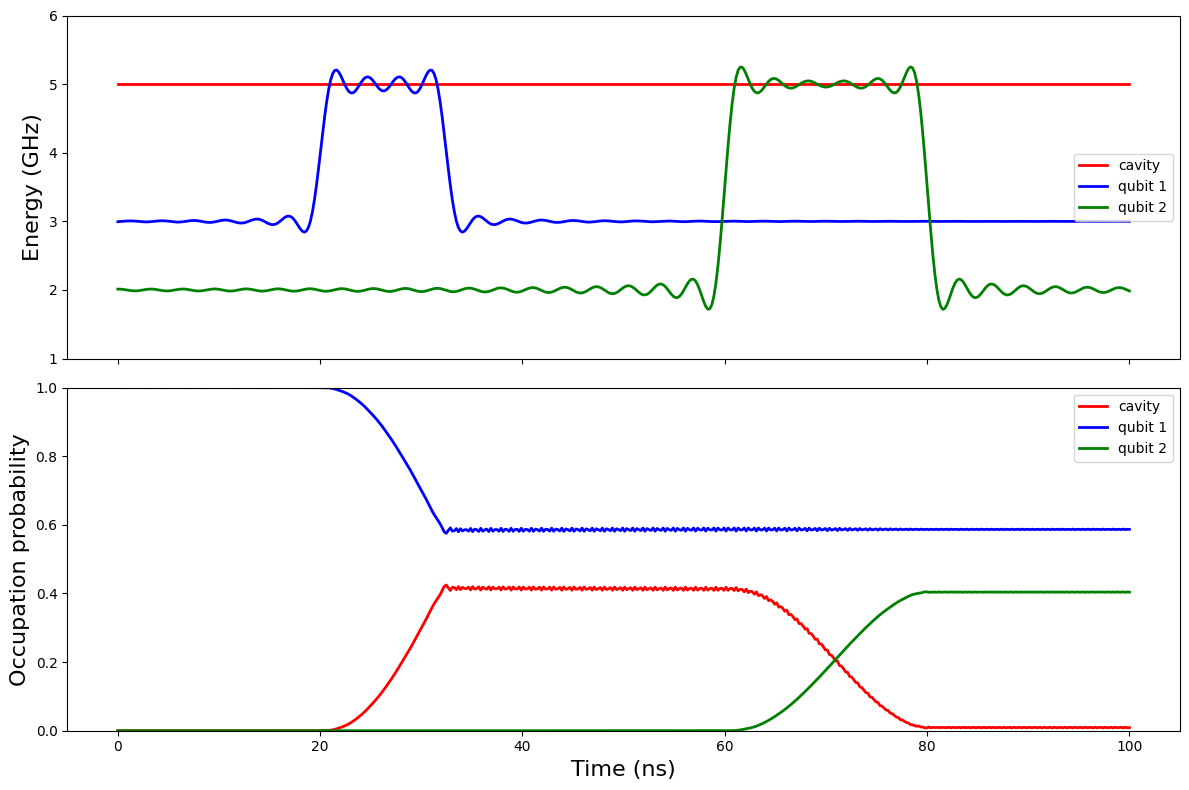

In [60]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [61]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [62]:
fidelity(rho_qubits, rho_qubits_ideal)

0.10760184935513732

In [63]:
concurrence(rho_qubits)

0.9737582606156453

# Two-qubit iSWAP gate: Finite pulse rise time and dissipation

In [64]:
# increase the pulse rise time a bit
width = 0.6

# high-Q resonator but dissipative qubits
kappa  = 0.00001
gamma1 = 0.005
gamma2 = 0.005

c_ops = [math.sqrt(kappa) * a, math.sqrt(gamma1) * sm1, math.sqrt(gamma2) * sm2]

### Evolve the system

In [65]:
res = mesolve(H_t, psi0, tlist, c_ops, [])

### Plot results

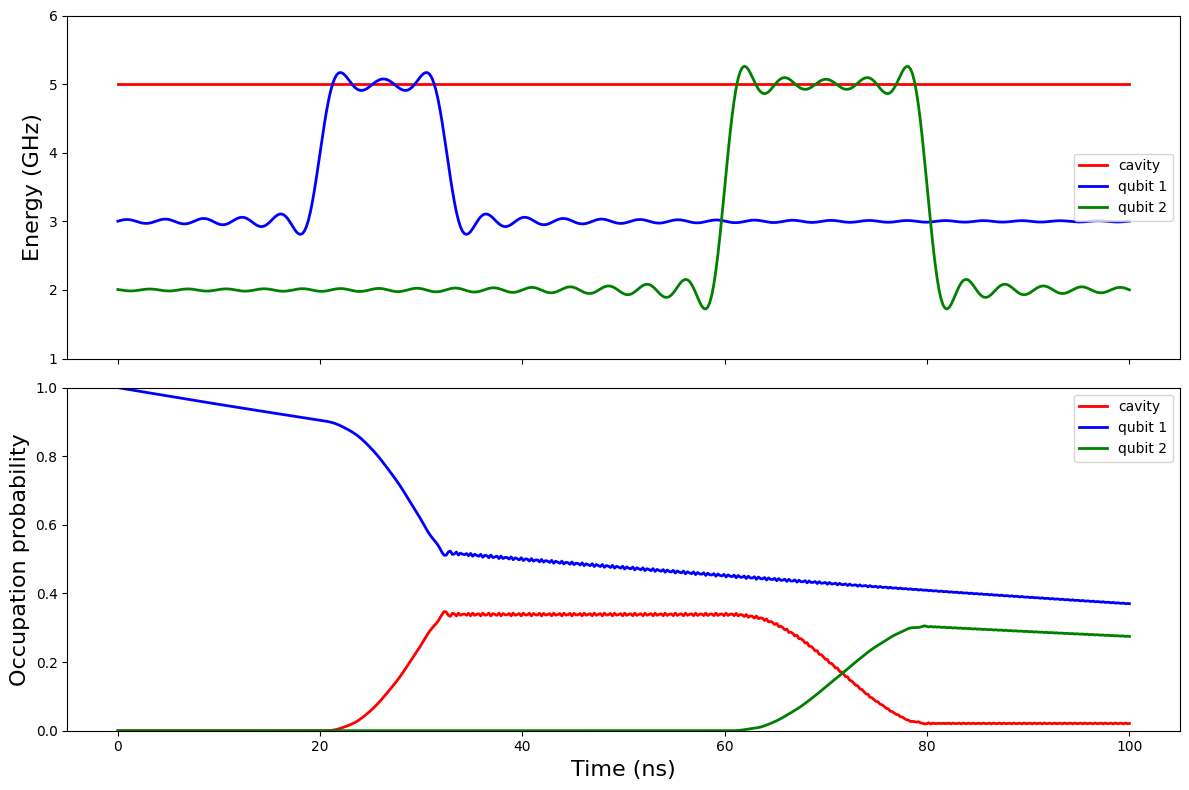

In [66]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [67]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [68]:
fidelity(rho_qubits, rho_qubits_ideal)

0.11877418022444815

In [69]:
concurrence(rho_qubits)

0.6261569127216249

# Two-qubit iSWAP gate: Using tunable resonator and fixed-frequency qubits

In [70]:
# reduce the rise time
width = 0.25

def wc_t(t, args=None):
    return wc - step_t(0.0, wc-w1, T0_1, width, t) + step_t(0.0, wc-w1, T0_1+T_gate_1, width, t) \
              - step_t(0.0, wc-w2, T0_2, width, t) + step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)

H_t = [[Hc, wc_t], H1 * w1 + H2 * w2 + Hc1+Hc2]

### Evolve the system

In [71]:
res = mesolve(H_t, psi0, tlist, c_ops, [])

### Plot the results

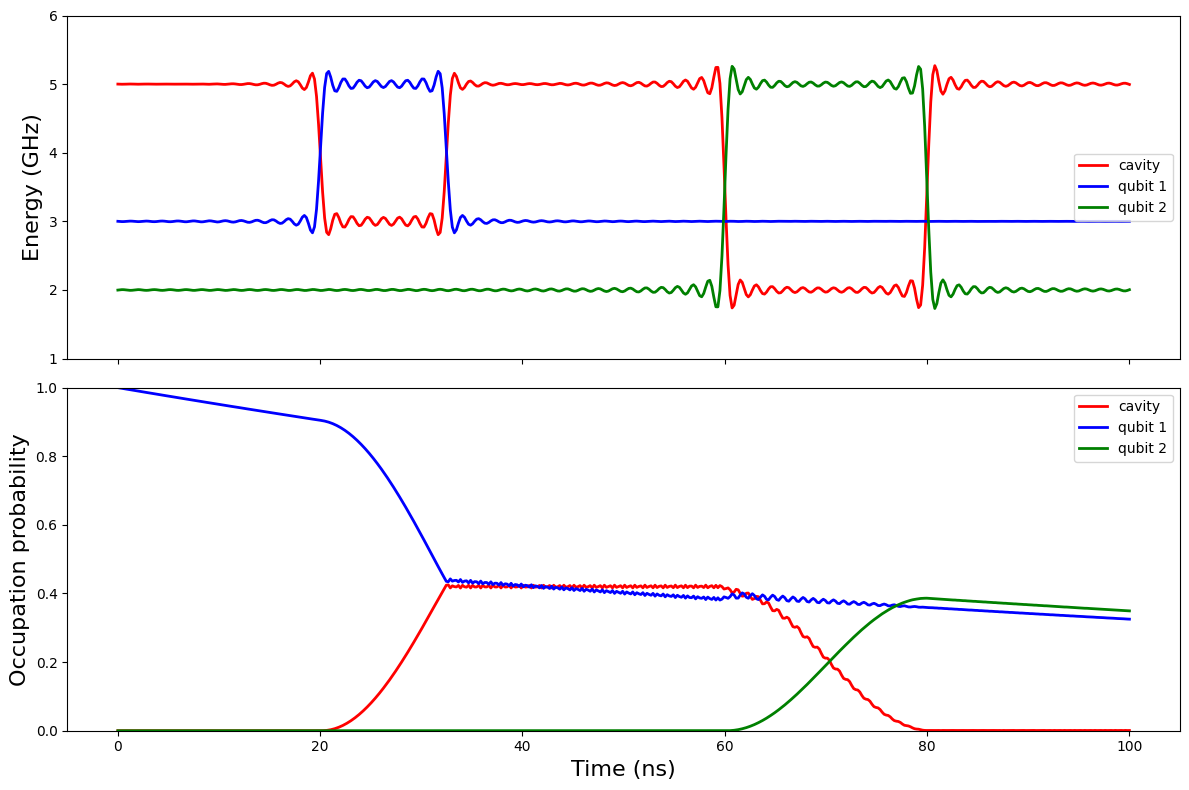

In [72]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*math.pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*math.pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*math.pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(expect(n, res.states)), 'r', linewidth=2, label="cavity")
axes[1].plot(tlist, np.real(expect(n1, res.states)), 'b', linewidth=2, label="qubit 1")
axes[1].plot(tlist, np.real(expect(n2, res.states)), 'g', linewidth=2, label="qubit 2")
axes[1].set_ylim(0, 1)

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()

### Fidelity and concurrence

In [73]:
rho_final = res.states[-1]
rho_qubits = ptrace(rho_final, [1,2])

In [74]:
fidelity(rho_qubits, rho_qubits_ideal)

0.02029339923336235

In [75]:
concurrence(rho_qubits)

0.6736823211144218

### Software versions

In [76]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,5.0.4
Numpy,1.26.4
SciPy,1.13.1
matplotlib,3.8.0
Number of CPUs,2
BLAS Info,Generic
IPython,7.34.0
Python,"3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]"
OS,posix [linux]
Cython,3.0.11
